In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/'
DATA_PATH = '/gdrive/My Drive/colab_files/polyphonic/'
print(os.getcwd())

/content


In [ ]:
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
print(os.getcwd())

os.chdir(BASE_PATH)
!ls
!tar -zxf mel_spec_polyphonic.tar.gz polyphonic/test
!tar -zxf mel_spec_polyphonic.tar.gz polyphonic/train
!tar -zxf mel_spec_polyphonic.tar.gz polyphonic/validation

/gdrive/My Drive/colab_files
hw1			       mel_spec_dataset_large
hw2			       mel_spec_dataset_poly
mel_spec_data_amp.tar.gz       mel_spec_data.tar.gz
mel_spec_data_combined.tar.gz  mel_spec_polyphonic.tar.gz
mel_spec_data_large.tar.gz     polyphonic
mel_spec_dataset	       project
mel_spec_dataset_amp	       pt_util.py
mel_spec_dataset_combined


In [ ]:
os.chdir(BASE_PATH)
!tar -zxf mel_spec_polyphonic.tar.gz polyphonic/train_data_poly_list.csv
!tar -zxf mel_spec_polyphonic.tar.gz polyphonic/test_data_poly_list.csv
!tar -zxf mel_spec_polyphonic.tar.gz polyphonic/valid_data_poly_list.csv
!cp "pt_util.py" "/gdrive/My Drive/colab_files/polyphonic/"

In [4]:
DATA_PATH = '/gdrive/My Drive/colab_files/polyphonic/'
os.chdir(DATA_PATH)
!ls
#!ls -1 | wc -l

logs	     test		      train_data_poly_list.csv
pt_util.py   test_data_poly_list.csv  validation
__pycache__  train		      valid_data_poly_list.csv


In [5]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import csv
import sys
import pickle
import re
import pt_util

!ls

logs	     test		      train_data_poly_list.csv
pt_util.py   test_data_poly_list.csv  validation
__pycache__  train		      valid_data_poly_list.csv


In [6]:
def create_dict():
    dict = {}
    with open('train_data_poly_list.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        count = 0
        for row in csv_reader:
            labels = row[1].split()
            for lab in labels:
              if lab not in dict:
                dict[lab] = count
                count = count + 1
    return dict

In [7]:
#COMBINED
class PolyphonicDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, dictionary, start_mset, stop_mset, dir):
        super(PolyphonicDataset, self).__init__()
        self.data = []
        self.labels = []
        self.dict = dictionary
        row_count = 0
        with open(data_file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                label_one_hot = [0 for _ in range(self.num_classes())]
                labs = row[1].split()
                for lab in labs:
                    lab_num = self.dict[lab]
                    label_one_hot[lab_num] = 1
                self.labels.append(label_one_hot)
                

        for i in range(start_mset, stop_mset):
            name = dir + 'MSet' + str(i) + '.npy'
            data_np = np.load(name)
            for sample in data_np:
                self.data.append(sample)
            print('read' + name)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_array = self.data[idx]
        
        data_image = np.stack([data_array]*3)
        data_image = data_image.astype('float32')
        
        label_num = self.labels[idx]
        label_tensor = torch.tensor(label_num, dtype=torch.float)
        return data_image, label_tensor

    def num_classes(self):
        return len(self.dict)   


dictionary = create_dict()
print(dictionary)



{'gun_shot': 0, 'mixer': 1, 'cat_meowing': 2, 'crowd_cheering': 3, 'glass_smash': 4, 'horsewalk': 5, 'footsteps': 6, 'alarms_and_sirens': 7, 'dog_barking': 8, 'bird_singing': 9, 'crowd_applause': 10, 'baby_crying': 11, 'thunder': 12, 'rain': 13, 'bus': 14, 'motorcycle': 15}


In [8]:
#COMBINED
print('Loading test data set...')
data_test = PolyphonicDataset('test_data_poly_list.csv', dictionary, 0, 20, 'test/') 
print('Length of test dataset:' + str(len(data_test)))
print('Loading train data set...')
data_train = PolyphonicDataset('train_data_poly_list.csv', dictionary, 40, 100, 'train/')
print('Length of train data set:' + str(len(data_train)))
print('Loading validation data set...')
data_valid = PolyphonicDataset('valid_data_poly_list.csv', dictionary, 20, 40, 'validation/')
print('Length of validation data set:' + str(len(data_train)))
print(data_train.num_classes())


Loading test data set...
readtest/MSet0.npy
readtest/MSet1.npy
readtest/MSet2.npy
readtest/MSet3.npy
readtest/MSet4.npy
readtest/MSet5.npy
readtest/MSet6.npy
readtest/MSet7.npy
readtest/MSet8.npy
readtest/MSet9.npy
readtest/MSet10.npy
readtest/MSet11.npy
readtest/MSet12.npy
readtest/MSet13.npy
readtest/MSet14.npy
readtest/MSet15.npy
readtest/MSet16.npy
readtest/MSet17.npy
readtest/MSet18.npy
readtest/MSet19.npy
Length of test dataset:7590
Loading train data set...
readtrain/MSet40.npy
readtrain/MSet41.npy
readtrain/MSet42.npy
readtrain/MSet43.npy
readtrain/MSet44.npy
readtrain/MSet45.npy
readtrain/MSet46.npy
readtrain/MSet47.npy
readtrain/MSet48.npy
readtrain/MSet49.npy
readtrain/MSet50.npy
readtrain/MSet51.npy
readtrain/MSet52.npy
readtrain/MSet53.npy
readtrain/MSet54.npy
readtrain/MSet55.npy
readtrain/MSet56.npy
readtrain/MSet57.npy
readtrain/MSet58.npy
readtrain/MSet59.npy
readtrain/MSet60.npy
readtrain/MSet61.npy
readtrain/MSet62.npy
readtrain/MSet63.npy
readtrain/MSet64.npy
readtr

In [9]:
data, label = data_train.__getitem__(0)
print(type(label))
print(label)

<class 'torch.Tensor'>
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [10]:
#preparing pretrained network
import torchvision.models as models
def get_vgg_model():
  model = models.vgg11(pretrained = True)
  model.features = nn.Sequential(*[model.features[i] for i in range(16)])
  model.avgpool = nn.Identity()
  model.classifier[0] =  nn.Linear(12288, 4096)
  model.classifier[6] = nn.Linear(4096, 16)
  
  #freezing weights from all layers
  for param in model.parameters(): # freeze
    param.requires_grad = False
  
  #unfreezing weight for classifier layers
  for i in range(7):
    for param in model.classifier[i].parameters(): # train the last linear layer.
      param.requires_grad = True
  model = model.cuda()
  return model
  #from torchsummary import summary
  #print(model)
  #summary(model.cuda(), (3, 96, 64))
#output = model(data[None, ...])
#print(output)

In [11]:
def save_model(model, file_path, num_to_keep=1):
    pt_util.save(model, file_path, num_to_keep)

def load_model(model, file_path):
    print('loading model')
    pt_util.restore(model, file_path)

def load_last_model(model, dir_path):
    print('loading last model')
    return pt_util.restore_latest(model, dir_path)


In [25]:
def prec_and_recall(model, device, data_loader, size):

  model.eval()
  sum_prec = 0
  sum_recall = 0
  criterion = F.binary_cross_entropy_with_logits
  losses = []
  count = 0
  incorrect = 0
  total_count = 0
  with torch.no_grad():
    for j, (inputs, classes) in enumerate(data_loader):
      inputs = inputs.to(device)
      classes = classes.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, classes)
      losses.append(loss.item())
      pred_classes = torch.sigmoid(outputs)
      
      for i in range(len(outputs)):
        target = classes[i].to(device)
        pred = pred_classes[i]
        target_positive = torch.sum(target == 1).float()
        pred_positive = torch.sum(pred > 0.5).float()
        
        true_positive = 0
        for k in range(len(pred)):
          total_count += 1
          if pred[k] > 0.5 and target[k] == 1:
            true_positive += 1
          if pred[k] > 0.5 and target[k] == 0:
            incorrect += 1
          elif pred[k] < 0.5 and target[k] == 1:
            incorrect += 1           
        if target_positive != 0 and pred_positive !=0:
          recall = true_positive / target_positive
          precision = true_positive / pred_positive
          count += 1
        elif target_positive == 0 and pred_positive == 0:
          recall = 1
          precision = 1
          count +=1
        else:
          recall = 0
          precision = 0
        sum_recall += recall
        sum_prec += precision

  hamming_loss = incorrect/(size * 16)
  print('Average precision ' + str(sum_prec.item()/count))
  print('Average recall ' + str(sum_recall.item()/count))
  print('Average loss ' + str(np.mean(losses)))
  print('Hamming loss ' + str(hamming_loss))
  print(' ')
  return sum_recall.item()/count, sum_prec.item()/count, np.mean(losses), hamming_loss


In [13]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    criterion = F.binary_cross_entropy_with_logits
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


Using device cuda
num cpus: 2
Loaded data
loading last model
Average precision 0.126239711699582
Average recall 0.6637219075649651
Average loss 0.6936459168300956
Hamming loss 0.5366271409749671
 
Thu Dec 17 01:37:18 2020 Train Epoch: 0 [0/20316 (0%)]	Loss: 0.693737
Thu Dec 17 01:37:21 2020 Train Epoch: 0 [6400/20316 (31%)]	Loss: 0.314246
Thu Dec 17 01:37:23 2020 Train Epoch: 0 [12800/20316 (63%)]	Loss: 0.259657
Thu Dec 17 01:37:26 2020 Train Epoch: 0 [19200/20316 (94%)]	Loss: 0.225695
Train
Average precision 0.8605683145192682
Average recall 0.6797371454116388
Average loss 0.20940431343309535
Hamming loss 0.07074780960819059
 
Test
Average precision 0.8039851387918995
Average recall 0.605109658694134
Average loss 0.24260055384450202
Hamming loss 0.08549077733860343
 
Saved /gdrive/My Drive/colab_files/polyphonic/logs/2.0/000.pt

Thu Dec 17 01:39:02 2020 Train Epoch: 1 [0/20316 (0%)]	Loss: 0.220867
Thu Dec 17 01:39:05 2020 Train Epoch: 1 [6400/20316 (31%)]	Loss: 0.211747
Thu Dec 17 01:

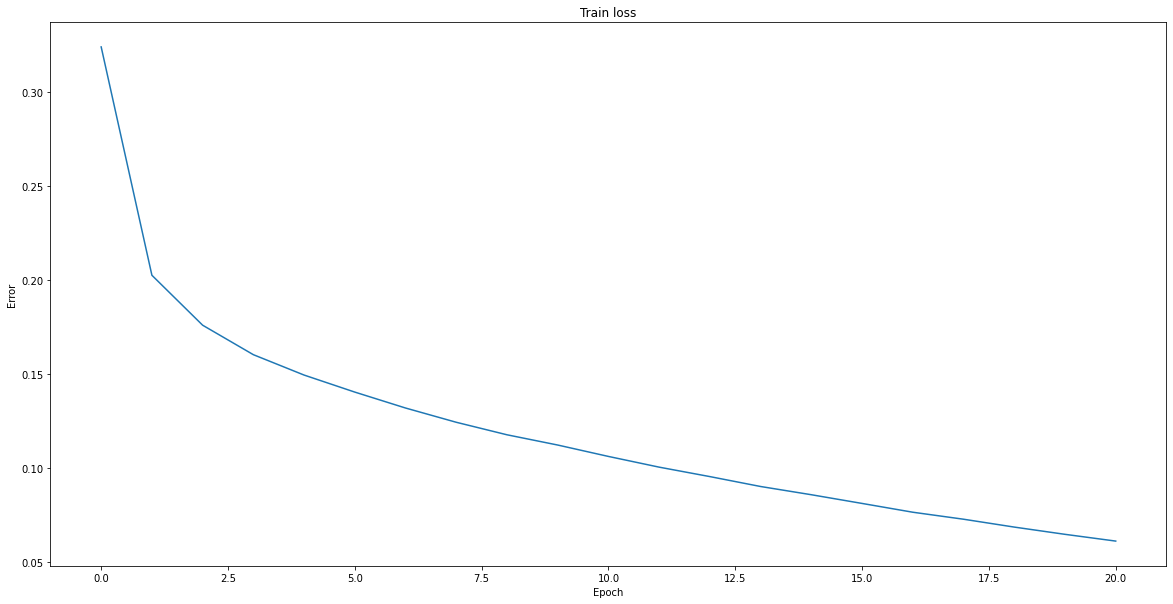

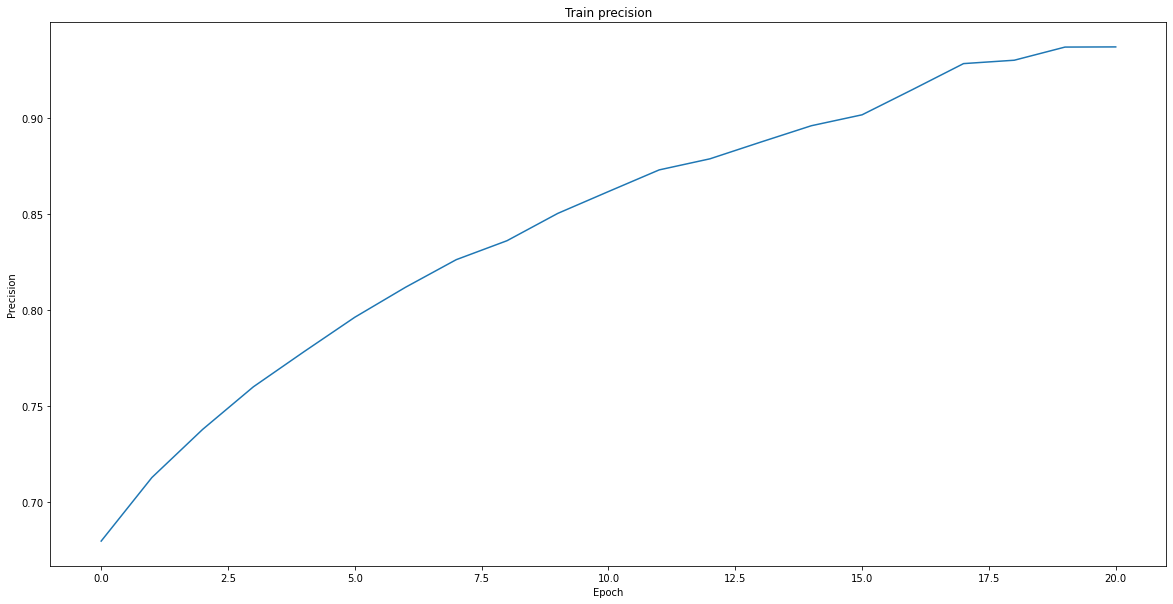

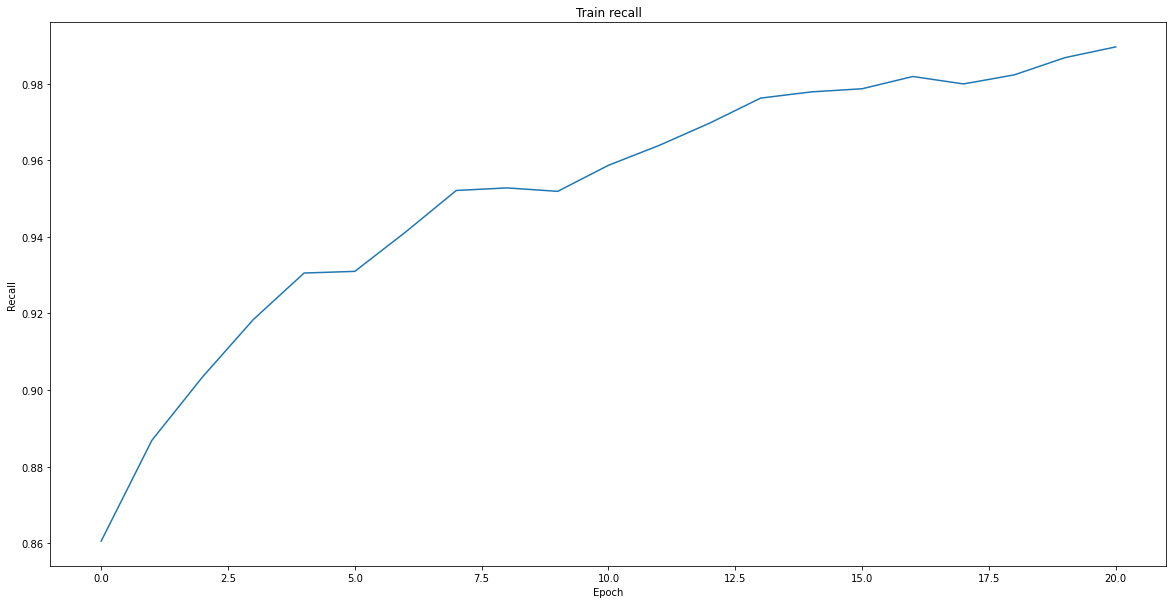

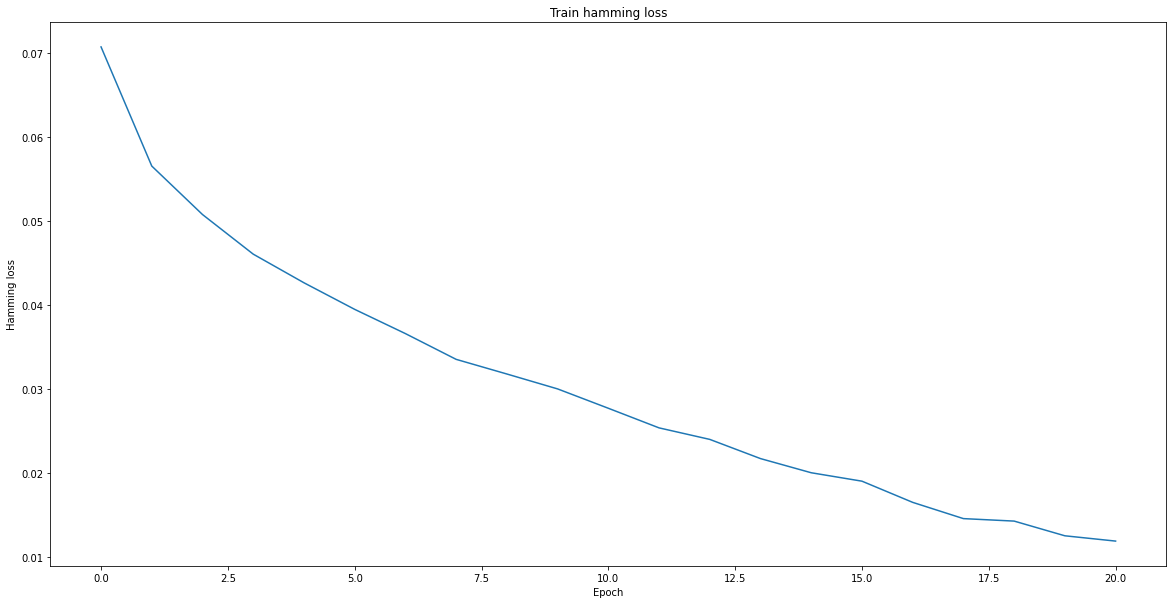

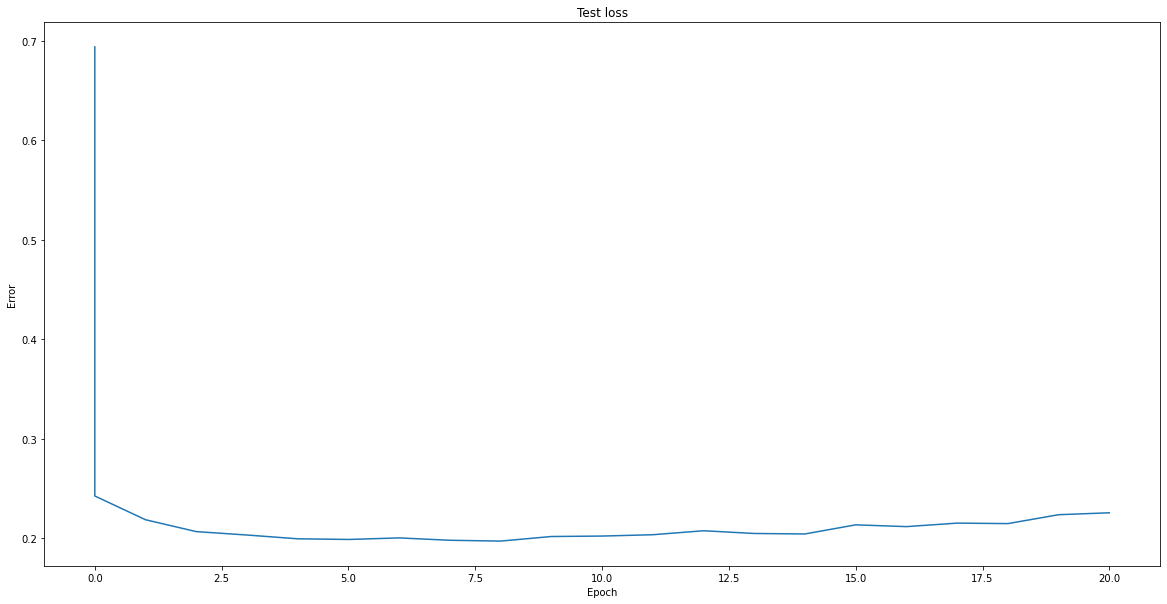

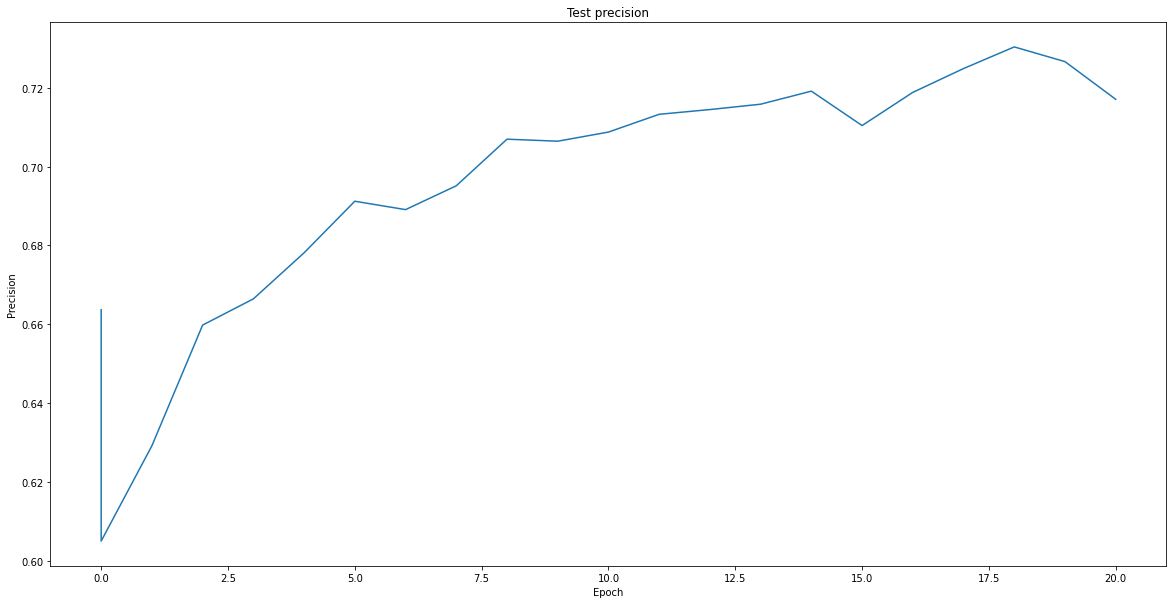

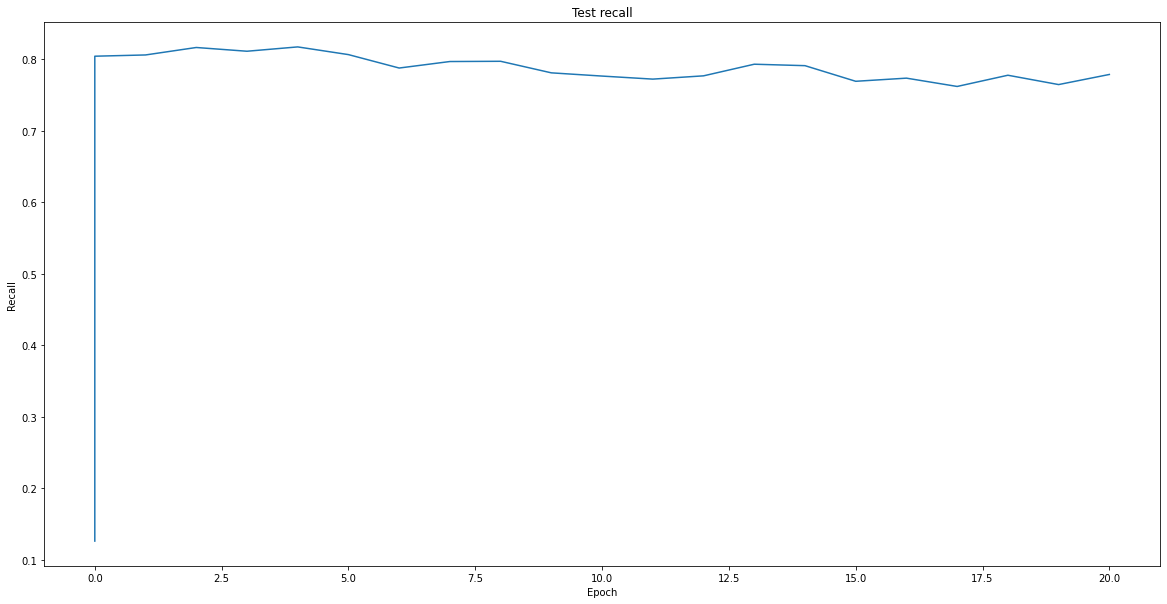

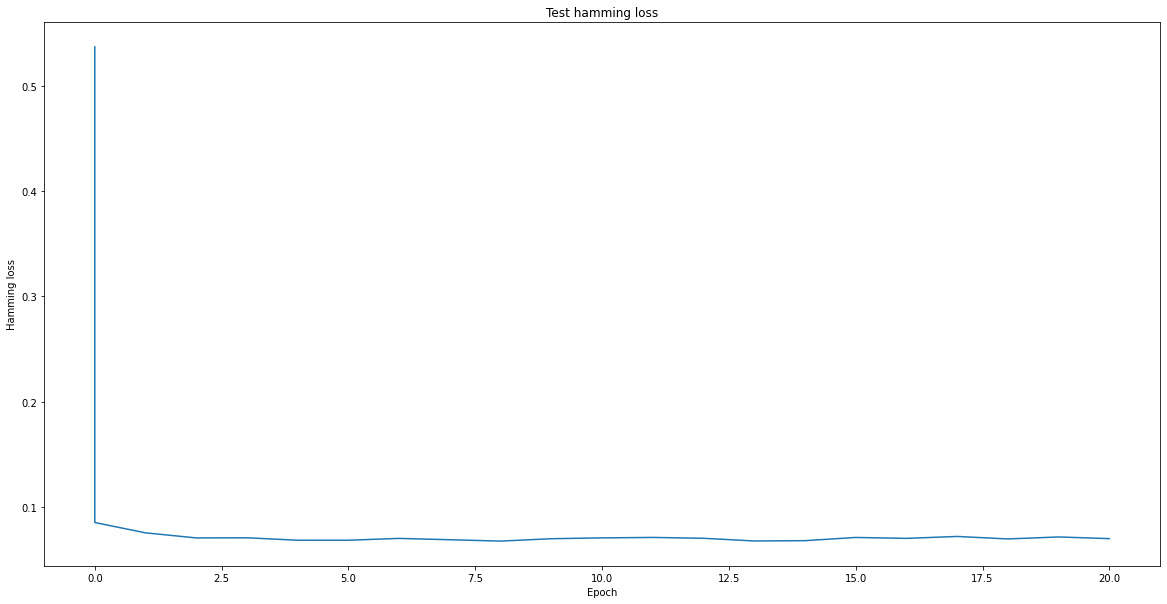

In [26]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 128
TEST_BATCH_SIZE = 10
EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 50
WEIGHT_DECAY = 0

EXPERIMENT_VERSION = "2.0" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)
train_size = len(data_train)
test_size = len(data_test)
print('Loaded data')
model = get_vgg_model()
#model = get_resnet_model()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

start_epoch = load_last_model(model, LOG_PATH)

train_losses, train_precs, train_recalls, train_hl, test_losses, test_precs, test_recalls, test_hl = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], [], [], [], [], [], []))
test_prec, test_recall, test_loss, test_hml = prec_and_recall(model, device, test_loader, test_size)

test_losses.append((start_epoch, test_loss))
test_precs.append((start_epoch, test_prec))
test_recalls.append((start_epoch, test_recall))
test_hl.append((start_epoch, test_hml))

lr = LEARNING_RATE
try:
    for epoch in range(start_epoch, EPOCHS + 1):
        #lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        optimizer = optim.SGD(model.parameters(), lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        
        print('Train')
        train_prec, train_recall, _ , train_hml = prec_and_recall(model, device, train_loader, train_size)
        print('Test')
        test_prec, test_recall, test_loss, test_hml = prec_and_recall(model, device, test_loader, test_size)
        train_losses.append((epoch, train_loss))
        train_precs.append((epoch, train_prec))
        train_recalls.append((epoch, train_recall))
        train_hl.append((epoch, train_hml))
        test_losses.append((epoch, test_loss))
        test_precs.append((epoch, test_prec))
        test_recalls.append((epoch, test_recall))
        test_hl.append((epoch, test_hml))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, train_precs, train_recalls, train_hl, test_losses, test_precs, test_recalls, test_hl))       
        save_model(model, LOG_PATH + '%03d.pt' % epoch)

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    save_model(model, LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*train_precs)
    pt_util.plot(ep, val, 'Train precision', 'Epoch', 'Precision')
    ep, val = zip(*train_recalls)
    pt_util.plot(ep, val, 'Train recall', 'Epoch', 'Recall')
    ep, val = zip(*train_hl)
    pt_util.plot(ep, val, 'Train hamming loss', 'Epoch', 'Hamming loss')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_precs)
    pt_util.plot(ep, val, 'Test precision', 'Epoch', 'Precision')
    ep, val = zip(*test_recalls)
    pt_util.plot(ep, val, 'Test recall', 'Epoch', 'Recall')
    ep, val = zip(*test_hl)
    pt_util.plot(ep, val, 'Test hamming loss', 'Epoch', 'Hamming loss')


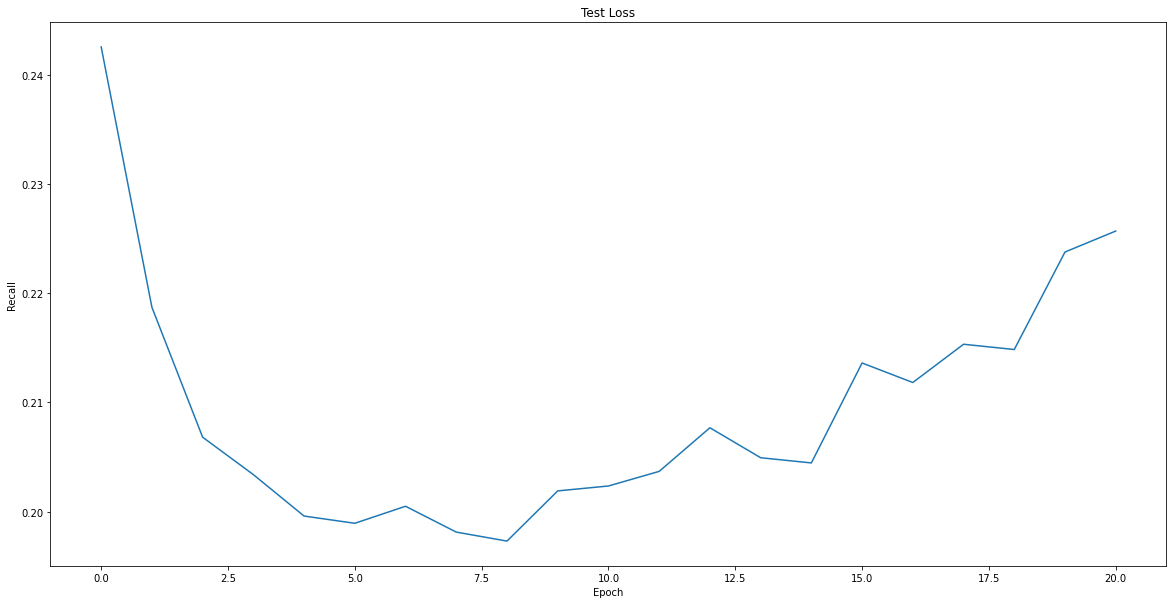

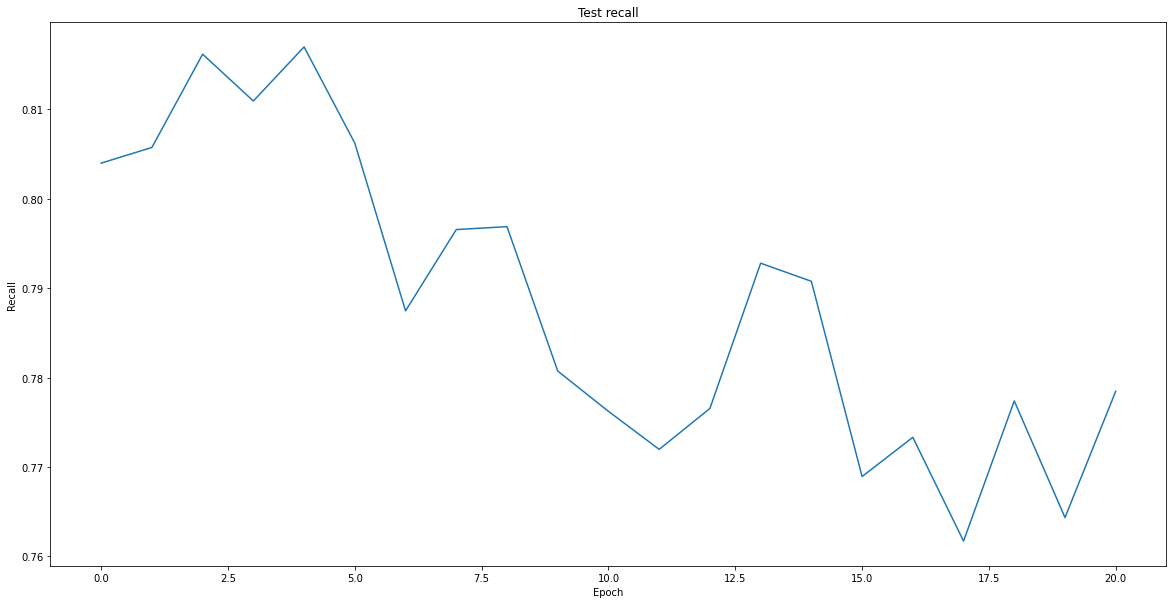

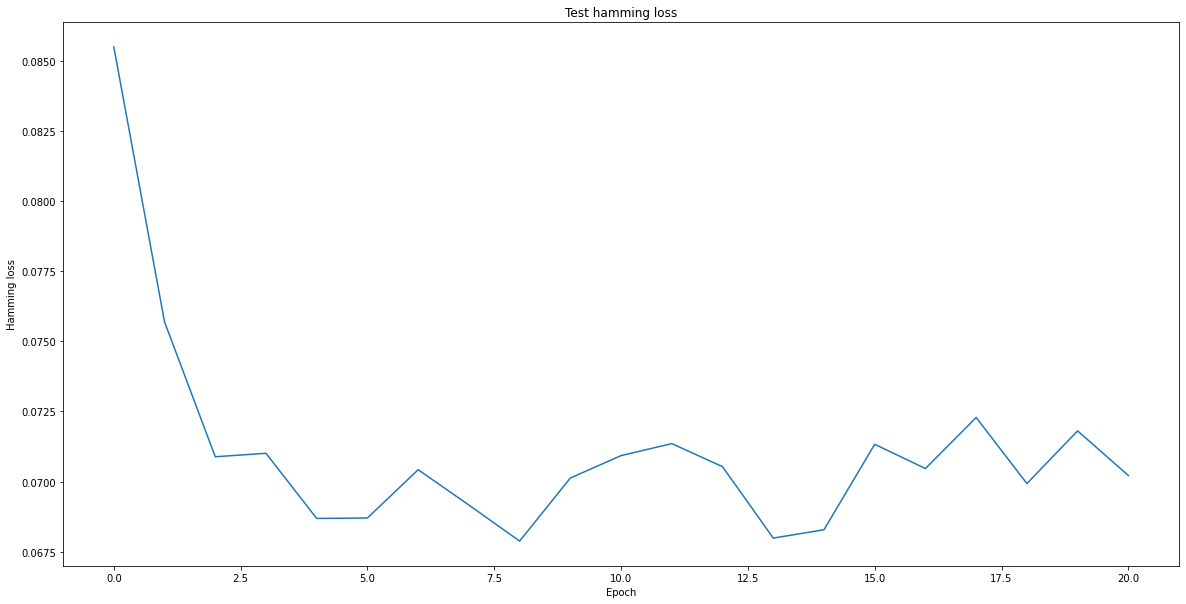

In [29]:
#INITIAL APPENDED VALUE OF TEST LOSS RECALL AND HAMMING IS TO LARGE TO GRAPH
#REMOVE FROM LIST TO SEE OTHER VALUES BETTER
ep, val = zip(*test_losses)
eplist = list(ep)
vallist = list (val)
eplist.pop(0)
vallist.pop(0)
pt_util.plot(eplist, vallist, 'Test Loss', 'Epoch', 'Recall')
ep, val = zip(*test_recalls)
eplist = list(ep)
vallist = list (val)
eplist.pop(0)
vallist.pop(0)
pt_util.plot(eplist, vallist, 'Test recall', 'Epoch', 'Recall')
ep, val = zip(*test_hl)
eplist = list(ep)
vallist = list (val)
eplist.pop(0)
vallist.pop(0)
pt_util.plot(eplist, vallist, 'Test hamming loss', 'Epoch', 'Hamming loss')